<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***30% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=1*365)            # 1 year before the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2024-05-30 to 2025-05-30
Time span: 365 days (1.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
from py.utils import load_and_filter_data

daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042249999999999996 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-05-30.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head())

Fetching page 1/15...
Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 1000 articles fetched
Fetching page 4/15...
Page 4: 999 articles fetched
Fetching page 5/15...
Page 5: 1000 articles fetched
Fetching page 6/15...
Page 6: 996 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 999 articles fetched
Fetching page 12/15...
Page 12: 998 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 1000 articles fetched
Fetching page 15/15...
Page 15: 999 articles fetched
Total articles fetched: 14991


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""DOLE""","""2025-06-02 06:51:54""","""Dole Is A Solid Buy - At The R…","""https://images.financialmodeli…","""seekingalpha.com""","""Dole plc appears attractively …","""https://seekingalpha.com/artic…"
"""AGYS""","""2025-06-02 06:51:04""","""New Strong Buy Stocks for June…","""https://images.financialmodeli…","""zacks.com""","""PVH, MMS, ALIZY, BPOP and AGYS…","""https://www.zacks.com/commenta…"
"""TKR""","""2025-06-02 06:51:00""","""Timken Names Timothy A. Graham…","""https://images.financialmodeli…","""prnewswire.com""","""NORTH CANTON, Ohio , June 2, 2…","""https://www.prnewswire.com/new…"
"""MAKOF""","""2025-06-02 06:50:00""","""Mako Mining Reports First Quar…","""https://images.financialmodeli…","""accessnewswire.com""","""VANCOUVER, BC / ACCESS Newswir…","""https://www.accessnewswire.com…"
"""BPMC""","""2025-06-02 06:50:00""","""Blueprint Medicines Soars 27% …","""https://images.financialmodeli…","""barrons.com""","""The deal announced Monday is S…","""https://www.barrons.com/articl…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head())
display(sector_summary)

# Export results
# sentiment_with_fundamentals.write_csv("data/combined_sentiment_fundamentals.csv")
# comprehensive_screened.write_csv("data/screened_stocks.csv")
# print("Files saved: combined_sentiment_fundamentals.csv and screened_stocks.csv")

Loading fundamental data...
Loaded 504 stocks, 4267 unique tickers
Analyzing sentiment for stock symbols...

Screened 1679 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BGM""",4,0.9,0.0,1.0,0.8,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""LPCN""",4,0.8,0.0,1.0,0.6,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""ATO""",3,0.7812,0.0,1.0,0.5623,3,0.5925,0.5929,"""Utilities""",2.4434e10,21.48,153.83
"""NSCIF""",3,0.7803,0.0,1.0,0.5606,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBY""",24,0.7785,0.0,1.0,0.5571,24,0.4936,0.5672,"""Consumer Cyclical""",1.3848e10,15.29,65.42


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Utilities""",28,0.592943,0.592546,16.892857,4.2423e10,20.590714
"""Communication Services""",19,0.579321,0.546226,26.894737,3.9629e11,NaN
"""Healthcare""",50,0.574864,0.544772,21.06,9.2366e10,NaN
"""Technology""",77,0.571122,0.524465,16.597403,2.1723e11,NaN
"""Consumer Cyclical""",50,0.567234,0.493556,12.86,1.1792e11,NaN
…,…,…,…,…,…,…
"""Industrials""",61,0.561123,0.479393,10.377049,5.8400e10,NaN
"""Energy""",21,0.556838,0.382505,6.095238,7.0078e10,NaN
"""Financial Services""",58,0.548759,0.376879,11.931034,1.0355e11,NaN


### Step 5: Select Top 100 stocks ***(by `averageSentimentScore`)***
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head())

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution.head())

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['PH', 'TMUS', 'MMC', 'GS', 'SO']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""ATO""",3,0.7812,0.0,1.0,0.5623,3,0.5925,0.5929,"""Utilities""",2.4434e10,21.48,153.83
"""BBY""",24,0.7785,0.0,1.0,0.5571,24,0.4936,0.5672,"""Consumer Cyclical""",1.3848e10,15.29,65.42
"""FI""",4,0.7242,0.0,0.75,0.4484,4,0.5245,0.5711,"""Technology""",8.8477e10,28.29,159.58
"""CHTR""",5,0.71,0.0,0.8,0.42,5,0.5462,0.5793,"""Communication Services""",5.5588e10,11.23,402.42
"""NXPI""",4,0.7,0.0,0.5,0.4,4,0.5245,0.5711,"""Technology""",4.9566e10,21.37,196.2



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",20,0.25249,0.626255,0.68956
"""Industrials""",17,0.234329,0.617171,0.738141
"""Utilities""",13,0.263185,0.631592,0.695192
"""Healthcare""",13,0.212708,0.606354,0.724277
"""Consumer Cyclical""",12,0.2552,0.627583,0.677983



Summary statistics for selected stocks:
Average sentiment score: 0.2451
Min sentiment score: 0.1751
Max sentiment score: 0.5623
Average company news score: 0.6226
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import suppress_output

quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
display(quotes.tail())

,ato,bby,fi,chtr,nxpi,gis,fis,ir,xom,nvr,...,ceg,coo,ulta,jnj,apa,bmy,khc,ew,dal,tsco
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-22,154.431000,70.760002,161.339996,409.929993,196.509995,53.340000,78.339996,81.199997,102.970001,7071.200195,...,291.470001,79.300003,410.390015,151.312805,16.740000,47.029999,26.107698,74.790001,48.500000,49.443241
2025-05-23,156.410004,69.919998,159.339996,406.359985,192.149994,53.380001,78.220001,80.379997,103.029999,7066.390137,...,297.489990,78.830002,407.040009,151.639999,16.850000,46.849998,25.910658,74.989998,47.919998,49.473106
2025-05-27,156.490005,72.220001,160.139999,411.130005,198.899994,54.130001,79.959999,82.589996,103.519997,7210.649902,...,309.059998,80.589996,421.309998,153.250000,17.309999,46.889999,26.432814,76.220001,49.400002,50.150002
2025-05-28,153.720001,71.519997,160.740005,407.380005,196.210007,53.369999,79.970001,81.839996,102.110001,7000.120117,...,308.049988,80.120003,417.010010,152.429993,17.180000,46.970001,26.147108,76.660004,48.599998,49.060001
2025-05-29,154.339996,66.320000,159.619995,395.809998,195.889999,53.990002,78.269997,82.150002,102.690002,7097.640137,...,303.369995,79.959999,421.790009,153.580002,17.340000,47.849998,26.620001,77.730003,48.500000,48.970001


### Step 7: Create Trading Signals
- Use `talib` library to create signals.

In [10]:
from py.technical_analysis import calculate_technical_indicators, generate_trading_signals

# Execute technical analysis
technical_indicators = calculate_technical_indicators(quotes)
trading_signals = generate_trading_signals(technical_indicators)
available_tickers = list(technical_indicators.keys())

# Display sample results for first ticker
sample_ticker = available_tickers[0]
print(f"\nSample indicators and signals for {sample_ticker}:")
display(technical_indicators[sample_ticker].tail())

✅ Technical indicators calculated for 100 tickers
✅ Trading signals generated for 100 tickers

Sample indicators and signals for ato:


,Close,SMA_20,SMA_50,SMA_200,EMA_12,EMA_26,EMA_50,ADX,PLUS_DI,MINUS_DI,RSI_14,RSI_21
Date,,,,,,,,,,,,
2025-05-22,154.431000,157.728664,154.007959,142.329164,156.552916,156.184434,154.098813,17.664839,46.035900,53.964100,46.035900,49.211673
2025-05-23,156.410004,157.685902,154.211825,142.488346,156.530929,156.201142,154.189448,16.494268,50.638421,49.361579,50.638421,52.219265
2025-05-27,156.490005,157.617803,154.360407,142.645095,156.524633,156.222540,154.279666,15.433395,50.821024,49.178976,50.821024,52.339066
2025-05-28,153.720001,157.363470,154.421966,142.793611,156.093151,156.037166,154.257718,15.093779,44.660620,55.339380,44.660620,47.966695
2025-05-29,154.339996,157.093396,154.514222,142.939855,155.823435,155.911450,154.260945,14.553987,46.231652,53.768348,46.231652,48.968598


### Step 8: Backtest Strategies and Select Top 10 Stocks ***(by CAGR & Volatility)***
- Use `bt` library for backtesting the strategy.

In [11]:
from py.technical_analysis import run_backtest, best_strategy_analysis

# Configuration constants
PORTFOLIO_CONFIG = {
    'min_cagr': 0.1,        # Minimum 10% CAGR
    'max_volatility': 0.3,  # Maximum 30% volatility
    'max_stocks': 10        # Maximum 10 stocks in portfolio
}

# Step 1: Run strategy backtesting
backtest_data = run_backtest(quotes, trading_signals, available_tickers)

# Step 2: Analyze best strategies and build portfolio
analysis_results = best_strategy_analysis(quotes, trading_signals, backtest_data, available_tickers, **PORTFOLIO_CONFIG)

# Step 3: Display results
selected_tickers = analysis_results['selected_tickers']
best_strategies_df = analysis_results['best_strategies_df']
print(f"\n📊 Best Strategies for {len(selected_tickers)} Selected Tickers:")
display(best_strategies_df.sort_values('cagr', ascending=False))

STRATEGY BACKTESTING ANALYSIS

🔄 Running strategy backtests...
🔄 Running 400 backtests silently...
  Progress: 5%
  Progress: 10%
  Progress: 15%
  Progress: 20%
  Progress: 25%
  Progress: 30%
  Progress: 35%
  Progress: 40%
  Progress: 45%
  Progress: 50%
  Progress: 55%
  Progress: 60%
  Progress: 65%
  Progress: 70%
  Progress: 75%
  Progress: 80%
  Progress: 85%
  Progress: 90%
  Progress: 95%
  Progress: 100%
✅ Backtesting completed

🔄 Portfolio Construction
📊 CAGR Filtering: 100 → 55 tickers (≥10.0%)
📊 Volatility Filtering: → 38 tickers (≤30.0%)
🏆 Selected top 10 performers:
  #1. gild: 44.43% CAGR, 25.20% Vol, Sharpe: 1.60 (EMA_Cross_Signal)
  #2. cnp: 44.24% CAGR, 20.01% Vol, Sharpe: 1.94 (EMA_Cross_Signal)
  #3. nvr: 37.58% CAGR, 23.11% Vol, Sharpe: 1.51 (SMA_Cross_Signal)
  #4. pm: 34.17% CAGR, 24.99% Vol, Sharpe: 1.31 (EMA_Cross_Signal)
  #5. fis: 33.65% CAGR, 25.11% Vol, Sharpe: 1.29 (SMA_Cross_Signal)
  #6. ndaq: 32.81% CAGR, 23.47% Vol, Sharpe: 1.34 (EMA_Cross_Signal)
  

,cagr,total_return,max_drawdown,sharpe_ratio,volatility,strategy
gild,0.444296,0.443933,-0.178775,1.595889,0.251977,EMA_Cross_Signal
cnp,0.442386,0.442024,-0.086500,1.944451,0.200085,EMA_Cross_Signal
nvr,0.375789,0.375489,-0.103269,1.506448,0.231133,SMA_Cross_Signal
pm,0.341667,0.341397,-0.234092,1.310546,0.249893,EMA_Cross_Signal
fis,0.336525,0.336260,-0.119635,1.286589,0.251137,SMA_Cross_Signal
ndaq,0.328092,0.327834,-0.138756,1.335290,0.234661,EMA_Cross_Signal
coo,0.322466,0.322213,-0.169293,1.168892,0.272229,SMA_Cross_Signal
anet,0.306970,0.306731,-0.096810,1.135100,0.266159,RSI_Signal
fcx,0.288189,0.287966,-0.058374,1.475021,0.183633,RSI_Signal
amd,0.287461,0.287238,-0.088035,1.081435,0.264037,RSI_Signal


### Step 9: Plot Results

📊 Generating Portfolio Charts...

📈 Portfolio Performance:


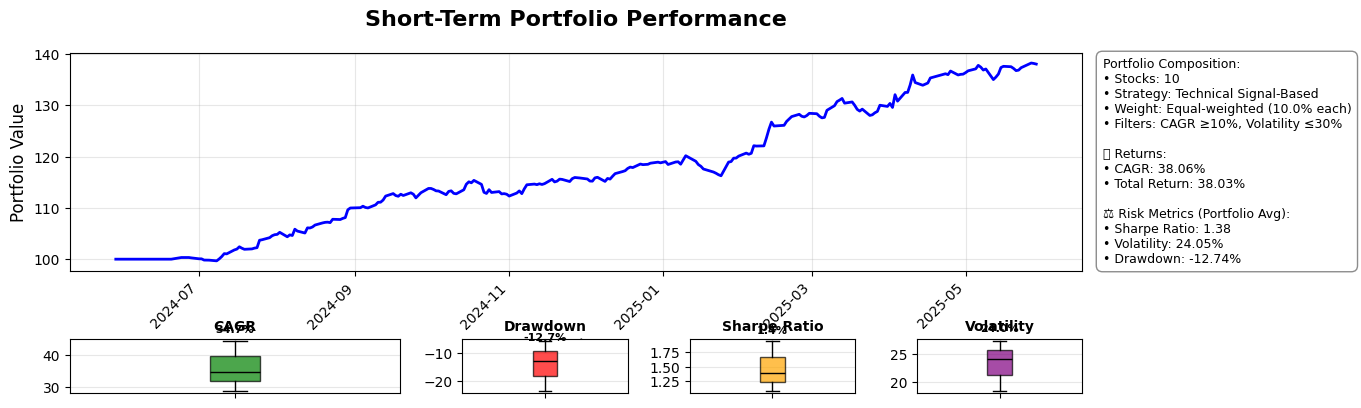


📈 Strategy Signals by Ticker:
📋 Included tickers: ['gild', 'cnp', 'nvr', 'pm', 'fis', 'ndaq', 'coo', 'anet', 'fcx', 'amd']
📊 Plotting 10 tickers that passed the 10% CAGR and ≤30% volatility thresholds


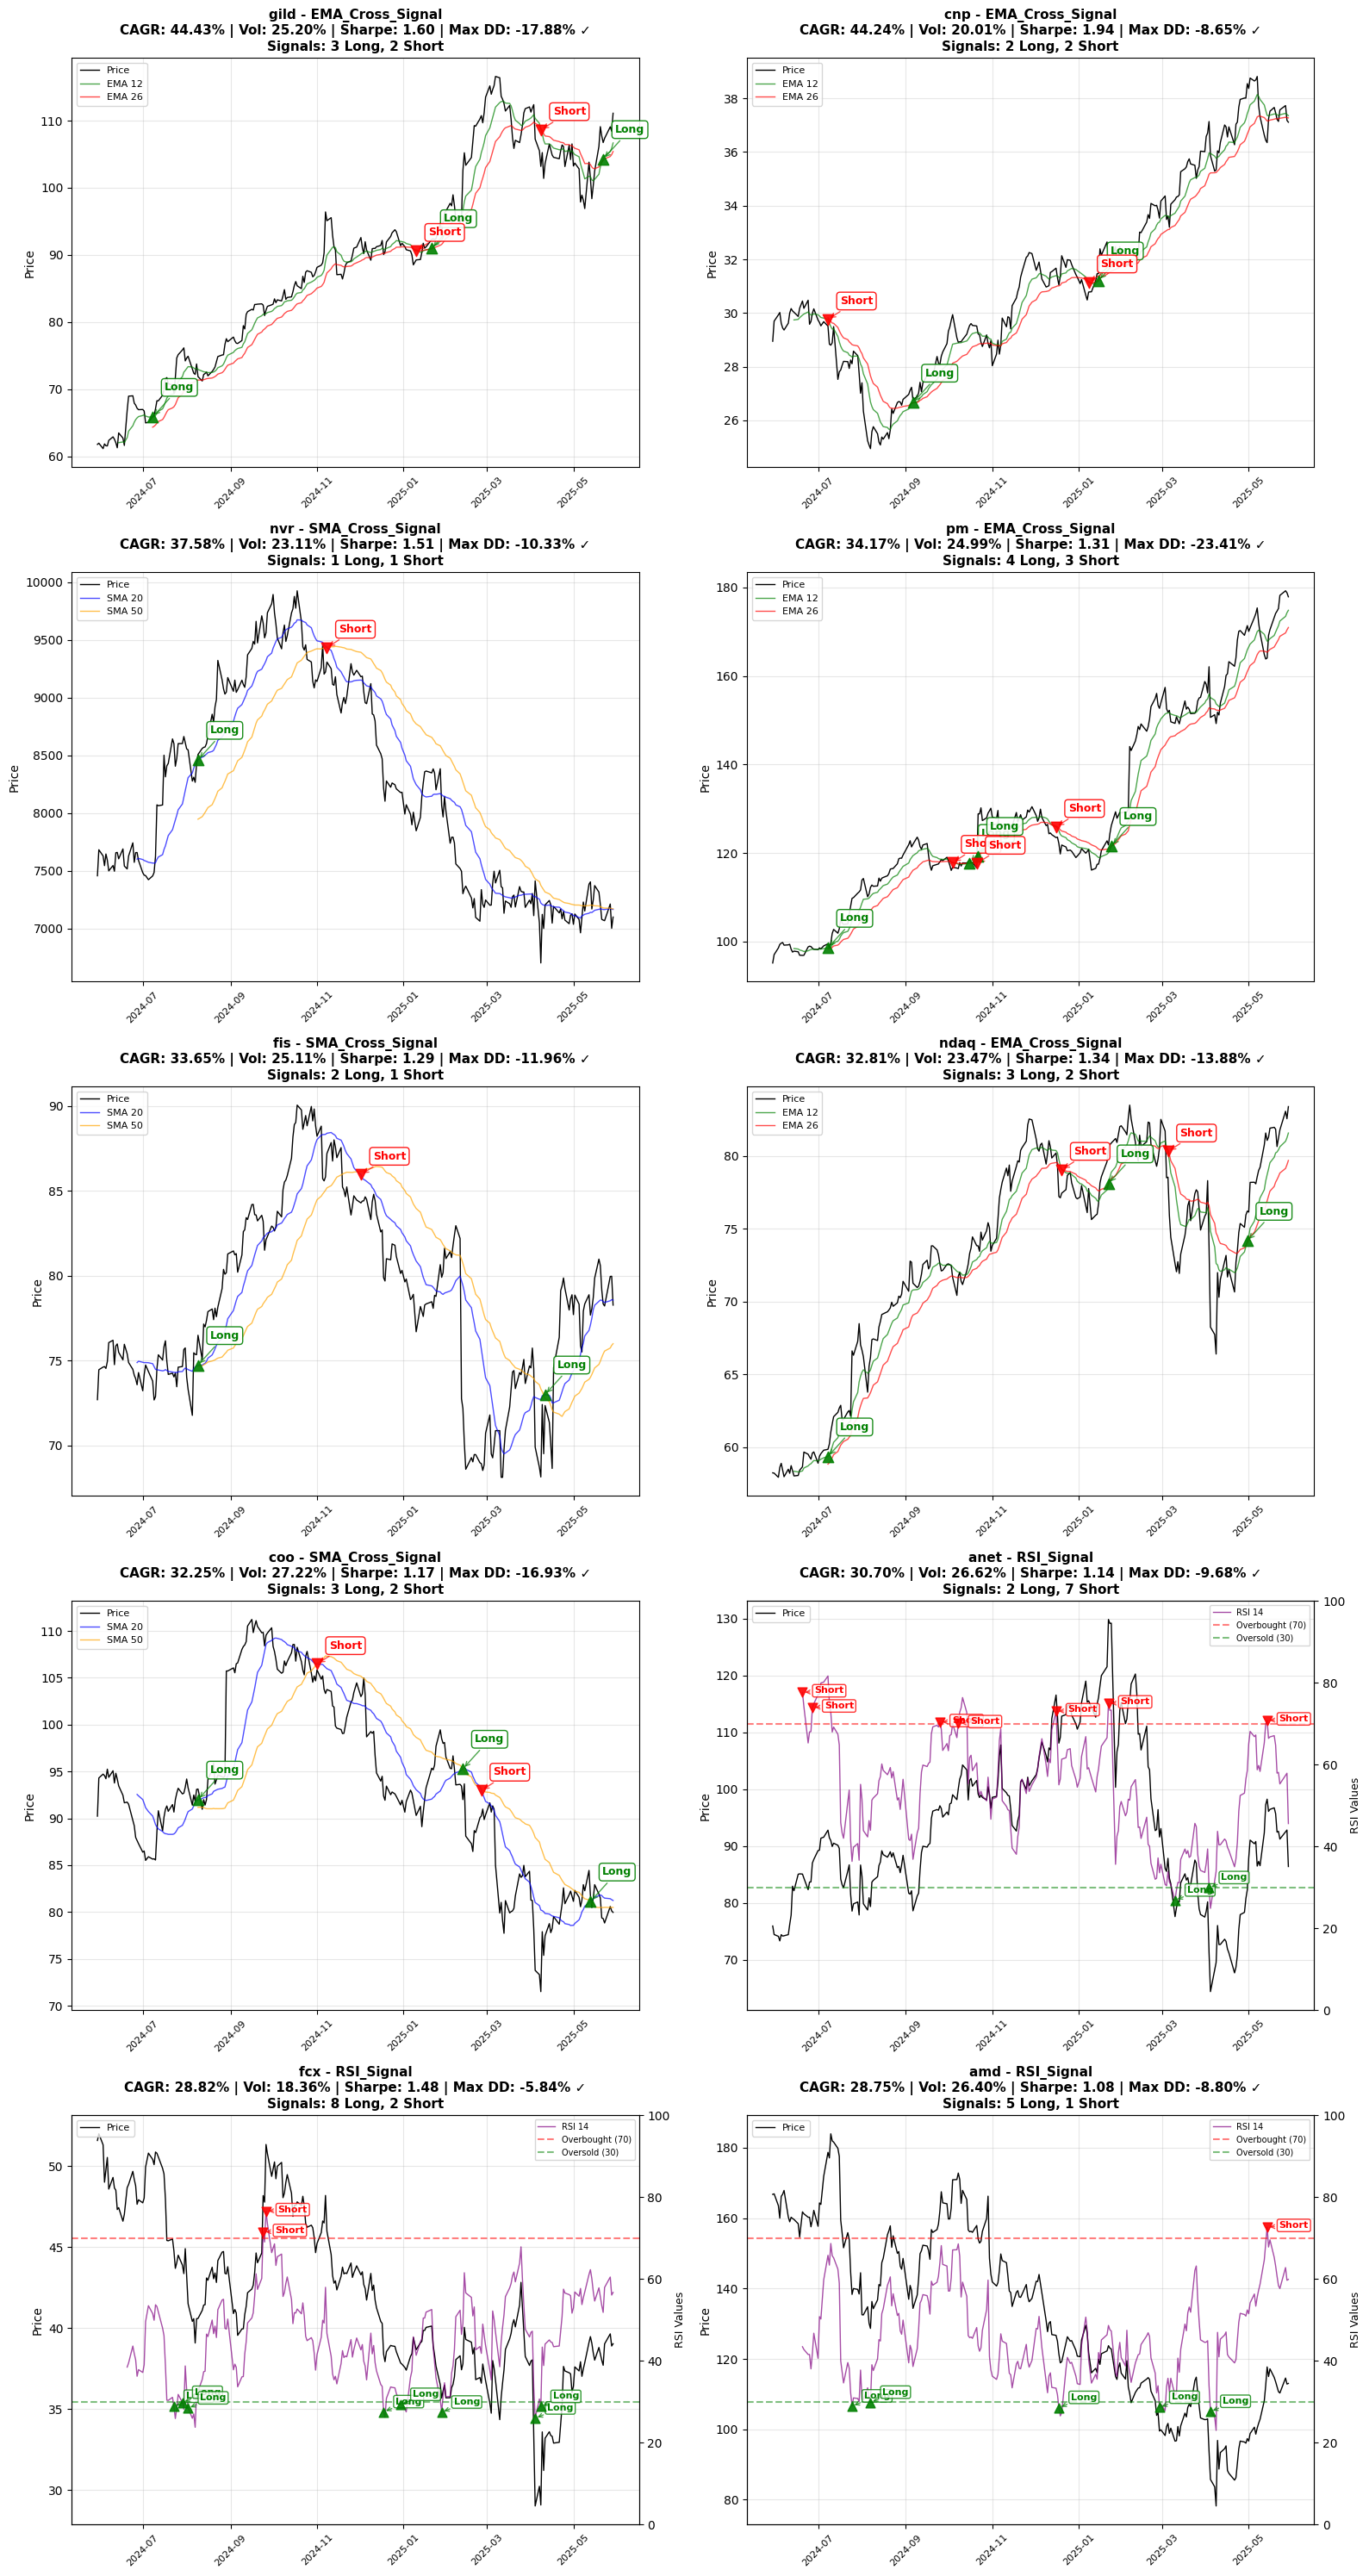


✅ Chart generation complete!


In [12]:
from py.technical_analysis import plot_portfolio_performance, plot_ticker_signals_with_annotations

# Chart generation
print("📊 Generating Portfolio Charts...")

for chart_type, func in [("Portfolio Performance", lambda: plot_portfolio_performance(analysis_results)), 
                         ("Strategy Signals by Ticker", lambda: plot_ticker_signals_with_annotations(
                             quotes, trading_signals, technical_indicators, 
                             analysis_results['best_strategies'], analysis_results['included_tickers'])
                          if all([quotes is not None, trading_signals, technical_indicators,
                                 all(key in analysis_results for key in ['best_strategies', 'included_tickers']),
                                 analysis_results['included_tickers']]) 
                          else print("⚠️ Missing required data or no tickers passed thresholds"))]:
    try:
        print(f"\n📈 {chart_type}:")
        if chart_type == "Strategy Signals by Ticker" and analysis_results.get('included_tickers'):
            print(f"📋 Included tickers: {analysis_results['included_tickers']}")
        func()
    except Exception as e:
        print(f"Error plotting {chart_type.lower()}: {e}")

print("\n✅ Chart generation complete!")

### Step 10: Merge Strategy with Fundamental + Sentiment Analysis Data

In [19]:
from py.utils import clean_column_names

print("Selected tickers from analysis_results:")
print(analysis_results['selected_tickers'])

# Create a DataFrame with tickers and merge with best_strategies_df
best_strategies_with_tickers = best_strategies_df.copy()
best_strategies_with_tickers['Ticker'] = [ticker.upper() for ticker in analysis_results['selected_tickers']] # Convert tickers to uppercase to match fundamentals_df format

# Convert to Polars for merging
best_strategies_pl = pl.DataFrame(best_strategies_with_tickers)

# Prepare comprehensive_screened for merging - select only needed columns
comprehensive_screened_for_merge = comprehensive_screened.select([
    'symbol',
    'articlesInLastWeek',
    'companyNewsScore', 
    'bearishPercent',
    'bullishPercent',
    'averageSentimentScore',
    'sectorAverageBullishPercent',
    'sectorAverageNewsScore'
    # Add other columns you want to keep, but exclude 'sector' to avoid duplication
]).with_columns(
    pl.col("symbol").str.to_uppercase().alias("Ticker")
).drop('symbol')  # Remove the original lowercase symbol column

# Chain all merges together
short_term_portfolio_pl = (fundamentals_df
    .join(best_strategies_pl, on='Ticker', how='inner')
    .join(comprehensive_screened_for_merge, on='Ticker', how='inner')
)

# Convert back to pandas if needed for further processing
short_term_portfolio_df = short_term_portfolio_pl.to_pandas()
short_term_portfolio_df = short_term_portfolio_df.set_index('Ticker').sort_index()
short_term_portfolio_df = clean_column_names(short_term_portfolio_df)
display(short_term_portfolio_df)

Selected tickers from analysis_results:
['gild', 'cnp', 'nvr', 'pm', 'fis', 'ndaq', 'coo', 'anet', 'fcx', 'amd']


,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,Shares Outstanding,...,Sharpe Ratio,Volatility,Strategy,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score
Ticker,,,,,,,,,,,,,,,,,,,,,
AMD,2025-05-29,"Advanced Micro Devices, Inc.",Technology,Semiconductors,United States,https://www.amd.com,1.841262e+11,1.804127e+11,1.610103e+09,1.621400e+09,...,1.081435,0.264037,RSI_Signal,78,0.5932,0.0385,0.7436,0.1864,0.5245,0.5711
ANET,2025-05-29,Arista Networks Inc,Technology,Computer Hardware,United States,https://www.arista.com,1.091520e+11,1.083874e+11,1.029429e+09,1.255920e+09,...,1.135100,0.266159,RSI_Signal,7,0.6251,0.0000,0.7143,0.2503,0.5245,0.5711
CNP,2025-05-29,"CenterPoint Energy, Inc.",Utilities,Utilities - Regulated Electric,United States,https://www.centerpointenergy.com,2.414049e+10,4.453944e+10,6.493668e+08,6.527280e+08,...,1.944451,0.200085,EMA_Cross_Signal,4,0.6131,0.0000,0.5000,0.2261,0.5925,0.5929
COO,2025-05-29,"The Cooper Companies, Inc.",Healthcare,Medical Instruments & Supplies,United States,https://www.coopercos.com,1.608954e+10,1.846169e+10,1.986073e+08,1.999570e+08,...,1.168892,0.272229,SMA_Cross_Signal,41,0.5899,0.0000,0.5610,0.1798,0.5448,0.5749
FCX,2025-05-29,Freeport-McMoRan Inc.,Basic Materials,Copper,United States,https://fcx.com,5.573174e+10,7.239883e+10,1.427325e+09,1.436200e+09,...,1.475021,0.183633,RSI_Signal,4,0.6064,0.0000,0.5000,0.2129,0.3571,0.5327
FIS,2025-05-29,"Fidelity National Information Services, Inc.",Technology,Information Technology Services,United States,https://www.fisglobal.com,4.111216e+10,5.330184e+10,5.240133e+08,5.253950e+08,...,1.286589,0.251137,SMA_Cross_Signal,6,0.6643,0.0000,1.0000,0.3286,0.5245,0.5711
GILD,2025-05-29,"Gilead Sciences, Inc.",Healthcare,Drug Manufacturers - General,United States,https://www.gilead.com,1.374232e+11,1.510487e+11,1.241354e+09,1.243930e+09,...,1.595889,0.251977,EMA_Cross_Signal,12,0.6125,0.0000,0.5833,0.2250,0.5448,0.5749
NDAQ,2025-05-29,"Nasdaq, Inc.",Financial Services,Financial Data & Stock Exchanges,United States,https://www.nasdaq.com,4.748850e+10,5.647174e+10,5.120017e+08,5.741220e+08,...,1.335290,0.234661,EMA_Cross_Signal,3,0.6449,0.0000,1.0000,0.2898,0.3769,0.5488
NVR,2025-05-29,"NVR, Inc.",Consumer Cyclical,Residential Construction,United States,https://www.nvrinc.com,2.064926e+10,1.935748e+10,2.879740e+06,2.923830e+06,...,1.506448,0.231133,SMA_Cross_Signal,3,0.6592,0.0000,1.0000,0.3185,0.4936,0.5672


### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [20]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = quotes[selected_tickers].join(daily_risk_free_df, how='inner')

# Convert all column names to uppercase
daily_prices_df_merged.columns = daily_prices_df_merged.columns.str.upper()

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

,AMD,ANET,CNP,COO,FCX,FIS,GILD,NDAQ,NVR,PM,^IRX
Date,,,,,,,,,,,
2025-05-01,112.860001,92.790001,37.180000,80.120003,38.889999,79.970001,108.440002,82.550003,7000.120117,178.789993,4.225
2025-04-01,97.349998,82.269997,38.546703,81.669998,36.029999,78.879997,106.540001,76.209999,7125.750000,171.360001,4.190
2025-03-01,102.739998,77.480003,36.012047,84.349998,37.691734,74.680000,112.050003,75.860001,7244.390137,158.729996,4.190
2025-02-01,99.860001,93.050003,34.173176,90.379997,36.745956,70.720848,113.513306,82.504715,7245.580078,153.921326,4.193
2025-01-01,115.949997,115.230003,32.165138,96.550003,35.690666,81.012756,96.522552,82.066177,8016.180176,129.060776,4.188
2024-12-01,120.790001,110.529999,31.335579,91.930000,37.766792,80.316681,91.726227,77.052910,8178.899902,119.296959,4.208
2024-11-01,137.179993,101.455002,32.214516,104.459999,43.836456,84.463455,91.168472,82.469757,9235.580078,130.447052,4.373
2024-10-01,144.070007,96.610001,28.968937,104.680000,44.649708,88.850006,87.465797,73.456612,9152.809570,130.094116,4.432
2024-09-01,164.080002,95.955002,28.861027,110.339996,49.357410,82.928650,82.561722,72.552322,9811.799805,119.016029,4.498


#### Export DataFrame to Excel

In [21]:
from py.utils import export_to_excel

export_to_excel(output_file, {
    'short_term': short_term_portfolio_df,
    'daily_quotes': daily_prices_df_merged,  
    'monthly_quotes': monthly_prices_df_merged   
})

Updated sheet 'short_term'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-05-30.xlsx
